# Assignment 1

### Business Understanding

Introduction - The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the spirits purchase detail of Iowa Class “E” liquor license holders by product, date of purchase, and location the item was purchased from. The timeframe of this data starts from January 1, 2012 through 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale. 

1. Set Objectives: We are a new and emerging Whisky brand who specializes in single-malt Rye, and we have targeted the state of Iowa for our next brand expansion. Before doing so, our goal will be to identify and predict which markets are more likely to sell greater volumes of whiskey, so that we can more efficiently spend our marketing dollars and inventory with little waste or buyback. Related questions also include, which brands are going to sell the most in each market, what parts of the year are going to have higher whiskey sales as opposed to lower whiskey sales to optimize advertising dollars, and what features of a town are defining characteristics of a large whiskey seller. 

2. Product Project Plan: To meet our goals, we will first use the Google Bigquery API to access the publicly available Iowa Liquor Sales data via python and Jupyter Notebook. Since the dataset is over 17 million lines of data, we will focus just on 2 months worth of data to do the cleaning. From here, we will define a subset to grant us 30,000 observations, address missing values and begin to build models that could help us answer questions based on markets likely to sell more whiskey. For our data on times of the year when we will sell more whiskey, we will need to create a subset of a full year’s data to build a time series model. For the town features, we will need to include additional information about the zip codes of iowa (such as population, income, ect) to get more demographic detail on each market to assist with a program for a clustering problem. For each of these problems, we will create a training and testing data set to help tune our predictions. 

3. Business Success Criteria - For our prediction models of market sales, we will be consider our model successful if we are able to classify our alochol type with a strong precision, recall and accuracy using a cross validation. Ideally, if we are dealing with 5 alcohol types, we will want to be able to predict whiskey accurately over 20% of the time. 

From the sale price prediction problem, we will run a linear regression technique against the remaining features. For this technique, we will use Root Mean Square Error to evaluate the effectiveness. A strong criteria for performance would be if we can get within $3 as an RMSE.

## Data Mining Type - Describe the meaning and type of data for each attribute in the data file

The data was collected via Google’s BigQuery tool in their Cloud Platform. The data was publicly available within the platform as an educational resource. The data is regularly updated through BigQuery, but .csv files can be found via sites like Kaggle.com. 

The description of all 24 fields of the data attributes can be found at https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy. We are working with the fields to start out with, to help begin the process of feature reduction and correlation analysis. Some of the data has no useful information for analysis, which we will likely be removing eventually. 

Below is a description of each feature available in the data set.

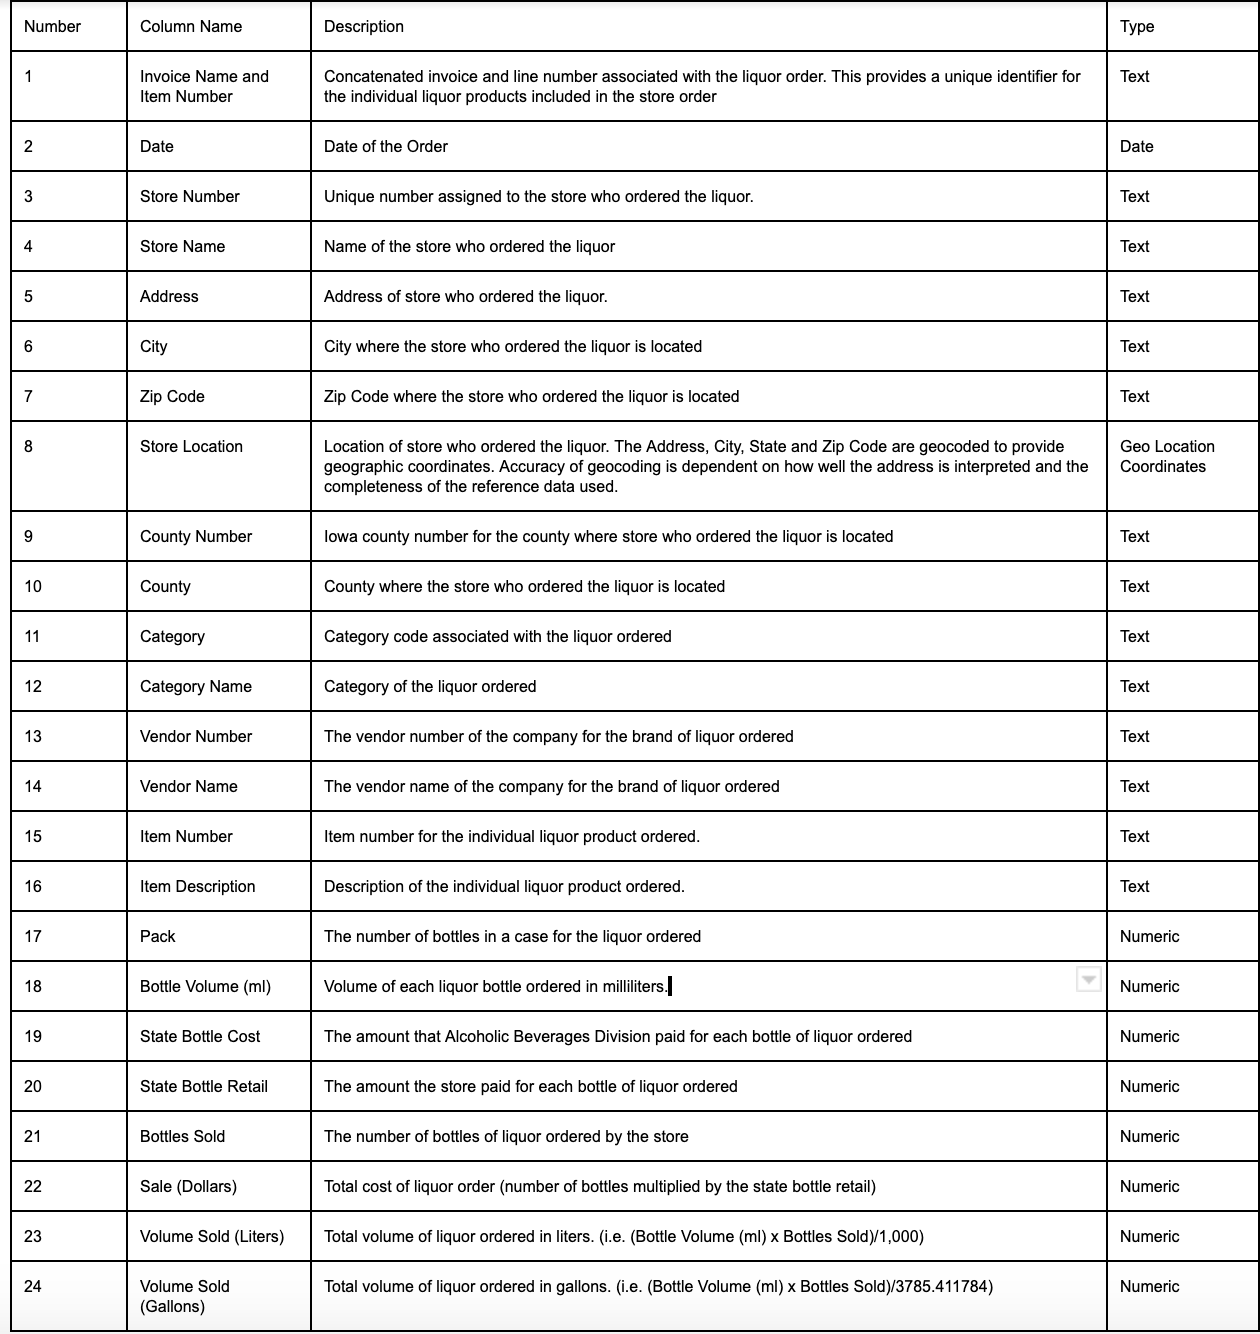

## Data Quality

In [4]:
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

In [5]:

try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import re

In [6]:
from google.cloud import bigquery

# Imports the Google Cloud client library
from google.cloud import storage
from google.oauth2 import service_account
import os
import pandas as pd

In [7]:
def implicit():
    from google.cloud import storage

    # This code asks python to look for your credentials in the environment. 
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

### Load in the Data

In order to load in our data, we will need to create a project id and save in our .json credentials from BigQuery onto our local machine. From there, we can set the client variable to map the credentials to our service account in our bigquery program. 

In [8]:
project = 'macro-campaign-202100'
credentials = service_account.Credentials.from_service_account_file(r'/Users/danielclark/Desktop/SMU/data_mining/My Project-71c2d48ddfb0.json')

client = bigquery.Client(credentials=credentials, project=project)


In [19]:
begindate = '2019-01-01'
enddate = '2019-12-31'
  
query = "select count(*) FROM `bigquery-public-data.iowa_liquor_sales.sales` where date > '" +begindate + "' and date <= '" + enddate +"' --LIMIT " 
    

df = client.query(query).to_dataframe()

For our measurement, we will be querying the first two months of data in 2012 (from Jan 01 through March 01, 2012) using our SQL command limiting our data to the first 30,000 rows. 

In [20]:
df.info

<bound method DataFrame.info of        f0_
0  2380345>

In [26]:
df.to_csv(index=False)

'f0_\n2380345\n'

In [57]:
query2 = "SELECT * FROM `bigquery-public-data.census_bureau_acs.zip_codes_2017_5yr` -- where geo_id = '51012' LIMIT 1000"
censusdf = client.query(query2).to_dataframe()
censusdf['zip_code'] = censusdf['geo_id']

In [58]:
df.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'], dtype=object)

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

### Data Cleaning

In our data cleaning step, we need to perform two specific data cleaning operations. 1.) We will need to convert our features to the correct continuous, ordinal and categorical features, and 2.) we will need to address the missing values. 

To begin the process of addressing missing values so that we can convert our data types, we will replace all "?", which our dataset denotes as null, into "-1" values (not strings). From here, we will convert state_bottle_cost, state_bottle_retail, sale_dollars, volume_sold_liters, and volume_sold_gallons into continuous variables so they register as floats. 


In addition, we will need to convert the varaible "bottles_sold" into ordinal features so they register as an integer value in our models. 

Thirdly, we will want to replace the values for pack, bottle_volume_ml, store_number, store_name, address, city, zip_code, county_number, county, category, category_name, vendor_number, vendor_name, item_number and item_description into categorical variables so they register as a non-null object in our model.

Using a df.info function helps to verify this. 

In [59]:
import numpy as np
# replace '?' with -1, we will deal with missing values later
df = df.replace(to_replace='?',value=-1) 

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons']

# and the oridnal values to be integers
ordinal_features = ['bottles_sold']

# we won't touch these variables, keep them as categorical
categ_features = ['pack', 'bottle_volume_ml', 'store_number', 'store_name', 'address', 'city', 'zip_code',
                  'county_number', 'county', 'category', 'category_name', 'vendor_number',
                  'vendor_name', 'item_number', 'item_description'];

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
invoice_and_item_number    30000 non-null object
date                       30000 non-null object
store_number               30000 non-null object
store_name                 30000 non-null object
address                    30000 non-null object
city                       30000 non-null object
zip_code                   30000 non-null object
store_location             27208 non-null object
county_number              29944 non-null object
county                     29944 non-null object
category                   29998 non-null object
category_name              29988 non-null object
vendor_number              30000 non-null object
vendor_name                30000 non-null object
item_number                30000 non-null object
item_description           30000 non-null object
pack                       30000 non-null int64
bottle_volume_ml           30000 non-null int64
state_bottl

In [60]:
dfstats = df.describe() # will get summary of continuous or the nominals

# let's set those values to NaN, so that Pandas understand they are missing
df = df.replace(to_replace=-1,value=np.nan) # replace -1 with NaN (not a number)
print (df.info())
dfstats2 = df.describe() # scroll over to see the values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
invoice_and_item_number    30000 non-null object
date                       30000 non-null object
store_number               30000 non-null object
store_name                 30000 non-null object
address                    30000 non-null object
city                       30000 non-null object
zip_code                   30000 non-null object
store_location             27208 non-null object
county_number              29944 non-null object
county                     29944 non-null object
category                   29998 non-null object
category_name              29988 non-null object
vendor_number              30000 non-null object
vendor_name                30000 non-null object
item_number                30000 non-null object
item_description           30000 non-null object
pack                       30000 non-null int64
bottle_volume_ml           30000 non-null int64
state_bottl

From here, we are going to drop the following variables due to the fact that they will not play a factor in our prediction dataset. Rationale is below:

- store_name : removing due to avail of store_number variable, which will identify the specific store more succinctly
- store location: as we will be able to locate stores on zip code, city and county number, and there appears to be a bunch of nulls anyway.

In [61]:
dfna = df[df.isna().any(axis=1)]
dfna.isna().sum()

invoice_and_item_number       0
date                          0
store_number                  0
store_name                    0
address                       0
city                          0
zip_code                      0
store_location             2792
county_number                56
county                       56
category                      2
category_name                12
vendor_number                 0
vendor_name                   0
item_number                   0
item_description              0
pack                          0
bottle_volume_ml              0
state_bottle_cost             1
state_bottle_retail           1
bottles_sold                  0
sale_dollars                  1
volume_sold_liters            0
volume_sold_gallons           0
dtype: int64

Once we drop our store name, address, and store location variables, we can also look to address the county number nulls as well. Since 112 values is somewhat significant on a 30,000 value dataset, we can look to do some inputation with the other data. 

Since we can use city and zip code as a guide, let's take the values that appear in the respective city and zip code on other values, and replace it with the missing value. 

In [62]:
df = df.drop(['store_name', 'store_location', 'address', 'county_number', 'county'], axis=1)

In [63]:
df.head()

invoice_and_item_number        date store_number             city zip_code  \
0            S03725500001  2012-01-24         9002         LECLAIRE    52753   
1            S03784800002  2012-01-30         2539       IOWA FALLS    50126   
2            S04099400026  2012-02-15         2648  WEST DES MOINES    50265   
3            S03651300006  2012-01-19         2190       DES MOINES    50314   
4            S03932500026  2012-02-06         2652       MASON CITY    50401   

  category                category_name vendor_number  \
0  1011500        STRAIGHT RYE WHISKIES           306   
1  1081700  DISTILLED SPIRITS SPECIALTY           384   
2  1062050                 BARBADOS RUM           389   
3  1062050                 BARBADOS RUM            91   
4  1081015            IMPORTED AMARETTO           130   

                        vendor_name item_number  \
0  Mississippi River Distilling Co.       27110   
1               Piedmont Distillers      976036   
2      REMY COINTREAU USA         .       42666   
3                     Castle Brands      902144   
4       Disaronno International LLC       64136   

                         item_description  pack  bottle_volume_ml  \
0                    Windmill Rye Whiskey    12               375   
1  Junior Johnson Apple Pie Midnight Moon     6               750   
2                     Mt. Gay Eclipse Rum    12               750   
3                Gosling's Black Seal Rum    12               750   
4                      Disaronno Amaretto    12               750   

   state_bottle_cost  state_bottle_retail  bottles_sold  sale_dollars  \
0               9.08                13.63           420       5724.60   
1              13.56                20.34            18        366.12   
2               9.00                13.50            12        162.00   
3               8.50                12.75            12        153.00   
4              12.33                18.99            12        227.88   

   volume_sold_liters  volume_sold_gallons  
0               157.5                41.61  
1                13.5                 3.57  
2                 9.0                 2.38  
3                 9.0                 2.38  
4                 9.0                 2.38

In [50]:
df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]]

county_number         county category              category_name  \
232              78  Pottawattamie  1031080             VODKA 80 PROOF   
904            None           None  1081200             CREAM LIQUEURS   
1526           None           None  1022100                    TEQUILA   
1577           None           None  1022100                    TEQUILA   
2475           None           None  1011200  STRAIGHT BOURBON WHISKIES   
...             ...            ...      ...                        ...   
27534          None           None  1012100          CANADIAN WHISKIES   
27768          None           None  1012100          CANADIAN WHISKIES   
29027          None           None  1032080             IMPORTED VODKA   
29176          None           None  1012300             IRISH WHISKIES   
29298          None           None  1012200            SCOTCH WHISKIES   

       state_bottle_cost  state_bottle_retail  sale_dollars  
232                  NaN                  NaN           NaN  
904                12.50                18.75        112.50  
1526               12.50                18.74         18.74  
1577               10.49                15.73         47.19  
2475               12.49                18.74         37.48  
...                  ...                  ...           ...  
27534               6.63                 9.94        119.28  
27768               6.75                10.12         30.36  
29027              10.89                16.33         32.66  
29176              17.40                26.10        156.60  
29298               6.65                 9.97         49.85  

[69 rows x 7 columns]

In [14]:
#one hot encoding of categoricial variables
one_hot_df = pd.concat([pd.get_dummies(df[col],prefix=col) for col in categ_features], axis=1)

one_hot_df.head()

pack_1  pack_2  pack_3  pack_4  pack_5  pack_6  pack_8  pack_10  pack_12  \
0       0       0       0       0       0       0       0        0        1   
1       0       0       0       0       0       1       0        0        0   
2       0       0       0       0       0       0       0        0        1   
3       0       0       0       0       0       0       0        0        1   
4       0       0       0       0       0       0       0        0        1   

   pack_20  ...  item_description_Uv Vodka  \
0        0  ...                          0   
1        0  ...                          0   
2        0  ...                          0   
3        0  ...                          0   
4        0  ...                          0   

   item_description_Whitetail Caramel Flavored Whiskey  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   item_description_Windmill Rye Whiskey  item_description_Windsor Canadian  \
0                                      1                                  0   
1                                      0                                  0   
2                                      0                                  0   
3                                      0                                  0   
4                                      0                                  0   

   item_description_Windsor Canadian Pet  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   item_description_Windsor Canadian Supreme Whisky  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   item_description_Windsor Canadian Traveler  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   item_description_Wiser's Deluxe Canadian  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   item_description_Yukon Jack Canadian Liqueur  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   item_description_Yukon Jack Perma Frost Schnapps  
0                                                 0  
1                                                 0  
2                                                 0  
3                                                 0  
4                                                 0  

[5 rows x 5690 columns]

In [15]:
dfstats2

pack  bottle_volume_ml  state_bottle_cost  state_bottle_retail  \
count  20000.000000      20000.000000       20000.000000         20000.000000   
mean      12.291200        946.430050           8.713785            13.093113   
std        7.321611        456.191334           6.285912             9.429587   
min        1.000000        100.000000           0.000000             0.000000   
25%        6.000000        750.000000           4.970000             7.440000   
50%       12.000000        750.000000           7.350000            11.020000   
75%       12.000000       1000.000000          10.750000            16.330000   
max       48.000000       3000.000000         124.720000           187.080000   

       bottles_sold  sale_dollars  volume_sold_liters  volume_sold_gallons  
count  20000.000000  20000.000000        20000.000000         20000.000000  
mean       9.458850    111.425966            9.051326             2.391259  
std       20.089213    287.196846           26.874807             7.099564  
min        1.000000      0.000000            0.150000             0.040000  
25%        3.000000     27.600000            1.880000             0.500000  
50%        6.000000     65.320000            7.000000             1.850000  
75%       12.000000    125.820000           10.500000             2.770000  
max      690.000000  17581.200000         1207.500000           318.990000

In [16]:
df.head()

invoice_and_item_number        date store_number  \
0            S03842900002  2012-01-31         2614   
1            S04335300003  2012-02-29         2648   
2            S04042500056  2012-02-13         3820   
3            S03539800032  2012-01-11         2502   
4            S04132500055  2012-02-16         2190   

                         store_name                address             city  \
0      Hy-Vee #3 Food and Drugstore     1823 E KIMBERLY RD        DAVENPORT   
1                   Hy-Vee #4 / WDM          555 S 51ST ST  WEST DES MOINES   
2       Charlie's Wine and Spirits,          507 W 19th St       SIOUX CITY   
3  Hy-Vee Wine and Spirits / Ankeny  410 NORTH ANKENY BLVD           ANKENY   
4         Central City Liquor, Inc.           1460 2ND AVE       DES MOINES   

  zip_code                        store_location county_number    county  ...  \
0    52807  POINT (-90.548919 41.55678100000001)            82     Scott  ...   
1    50265          POINT (-93.773557 41.561197)            77      Polk  ...   
2    51103          POINT (-96.420193 42.510535)            97  Woodbury  ...   
3    50021                                  None            77      Polk  ...   
4    50314           POINT (-93.619787 41.60566)            77      Polk  ...   

  item_number                       item_description pack bottle_volume_ml  \
0       27110                   Windmill Rye Whiskey   12              375   
1        4096  Ardbeg 10 Yr Islay Single Malt Scotch    6              750   
2       64136                     Disaronno Amaretto   12              750   
3       64136                     Disaronno Amaretto   12              750   
4       64136                     Disaronno Amaretto   12              750   

  state_bottle_cost state_bottle_retail  bottles_sold  sale_dollars  \
0              9.08               13.63            60        817.80   
1             24.97               37.45            60       2247.00   
2             12.33               18.99            12        227.88   
3             13.33               19.99            12        239.88   
4             12.33               18.99            12        227.88   

   volume_sold_liters  volume_sold_gallons  
0                22.5                 5.94  
1                45.0                11.89  
2                 9.0                 2.38  
3                 9.0                 2.38  
4                 9.0                 2.38  

[5 rows x 24 columns]

In [18]:
# data joins

liquorandcensusdf = pd.merge(df, censusdf, how = 'left', on='zip_code')

In [20]:
liquorandcensusdf.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons', 'geo_id', 'nonfamily_households',
       'family_households', 'median_year_structure_built',
       'rent_burden_not_computed', 'rent_over_50_percent',
       'rent_40_to_50_percent', 'rent_35_to_40_percent',
       'rent_30_to_35_percent', 'rent_25_to_30_percent',
       'rent_20_to_25_percent', 'rent_15_to_20_percent',
       'rent_10_to_15_percent', 'rent_under_10_percent', 'total_pop',
       'male_pop', 'female_pop', 'median_age', 'white_pop', 'black_pop',
       'asian_pop', 'hispanic_pop', 'amerindian_pop', 'other_race_pop',
       'two_or_more_races_p

### Outliers

In [68]:
# this python magics will allow plot to be embedded into the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [73]:
df['category_name'].value_counts()


VODKA 80 PROOF               3507
CANADIAN WHISKIES            2604
STRAIGHT BOURBON WHISKIES    1547
SPICED RUM                   1509
BLENDED WHISKIES             1402
                             ... 
MISCELLANEOUS  BRANDIES        11
ANISETTE                       11
ROCK & RYE                     10
CREME DE ALMOND                 9
WHITE CREME DE MENTHE           9
Name: category_name, Length: 66, dtype: int64

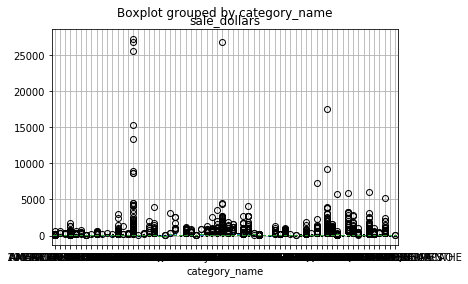

In [70]:
# pandas has some really powerful extensions to matplotlib for scientific computing 
ax = df.boxplot(column = 'sale_dollars', by = 'category_name')
ax

Looking at a quick boxplot of our 66 categories, along with the sale price, we can see there are a handfull of liquor sales that went north of $5,000, with two who have exceeded $25,000.

In [90]:
# selecting rows based on condition
exp_df = df[df['sale_dollars'] > 5000]

exp_df['cost_per_liter'] = exp_df['sale_dollars']/exp_df['volume_sold_liters']

print(exp_df[['sale_dollars', 'volume_sold_liters', 'cost_per_liter', 'category_name']])

       sale_dollars  volume_sold_liters  cost_per_liter          category_name
0           5724.60               157.5       36.346667  STRAIGHT RYE WHISKIES
818         7240.80                45.0      160.906667     SINGLE MALT SCOTCH
3975        6034.80               987.0        6.114286         VODKA 80 PROOF
6833        9172.80               630.0       14.560000             SPICED RUM
6851       17581.20              1207.5       14.560000             SPICED RUM
10325      27183.00              1020.0       26.650000      CANADIAN WHISKIES
10377      15350.40               576.0       26.650000      CANADIAN WHISKIES
10399      25584.00               960.0       26.650000      CANADIAN WHISKIES
16406       5144.04               297.0       17.320000        WHISKEY LIQUEUR
23080       5913.60               240.0       24.640000     TENNESSEE WHISKIES
26812       8952.00              1050.0        8.525714      CANADIAN WHISKIES
26816       8683.44              1018.5        8.525

/Users/danielclark/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


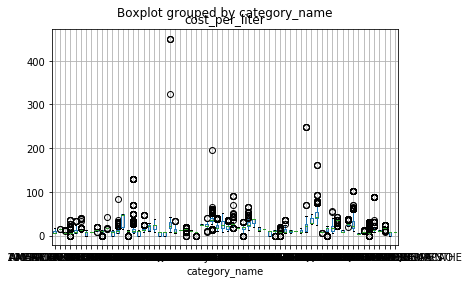

In [91]:
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']


bx = df.boxplot(column = 'cost_per_liter', by = 'category_name')
bx

## Simple Statistics

The df.describe funciton below provides some simple statistcs for the numeric values in the table. 

We can see that the average pack size is just over 12, with a median of exactly 12, so this would suggest our normality curve is very narrow (verified with the SD of 7.3 bottles and slightly right-skewed towards higher pack sizes. 

The average sale in our data set is $116.42 with a standard deviation of $415.62, which suggests there's a very wide variance of case prices in our data set. The median was $65.96 which suggests there are a few outliers in our data set for sales. Per our describe functions, the max sale was $27,183

All of our data has at least a count of 29,999 out of 30,000, with state_bottle_cost, state_bottle_retail, and sale_dollars.

In [64]:
df.describe()

pack  bottle_volume_ml  state_bottle_cost  state_bottle_retail  \
count  30000.000000      30000.000000       29999.000000         29999.000000   
mean      12.252300        933.413467           8.965390            13.475313   
std        7.284116        455.234764           5.898284             8.848587   
min        1.000000        100.000000           0.000000             0.000000   
25%        6.000000        750.000000           5.130000             7.690000   
50%       12.000000        750.000000           7.530000            11.300000   
75%       12.000000       1000.000000          11.160000            16.740000   
max       48.000000       3000.000000         124.720000           187.080000   

       bottles_sold  sale_dollars  volume_sold_liters  volume_sold_gallons  
count  30000.000000  29999.000000        30000.000000         30000.000000  
mean       9.255100    116.423600            8.676349             2.292188  
std       22.818339    415.615796           31.381803             8.290214  
min        1.000000      0.000000            0.100000             0.030000  
25%        3.000000     27.600000            1.750000             0.460000  
50%        6.000000     65.960000            4.800000             1.270000  
75%       12.000000    127.840000           10.500000             2.770000  
max     1800.000000  27183.000000         3150.000000           832.140000